In [1]:
from PIL import Image
from PIL import ImageFilter
!pip install --upgrade pip
!pip install imutils
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
image_dir="../input/brain-mri-images-for-brain-tumor-detection/"
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/yes')
os.makedirs('../output/kaggle/working/augmented-images/no')

     |████████████████████████████████| 1.5 MB 422 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1
  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=5356b400984c9d7c49140a547745d1726c8acea00b77e6693e277d3d34e477cc
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


Using TensorFlow backend.


## Augmentation of images 
**About the data:
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous.**

In [2]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        
#         if (filename=='N1' or filename=='N11' or filename=='N15' or filename=='N16' or filename=='N17' or filename=='N19' or filename=='N22'): 
#             for batch in data_gen.flow(x=image, batch_size=1, save_to_dir='yes',save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break
#         elif (filename=='Y185' or filename=='Y187'):
#             for batch in data_gen.flow(x=image, batch_size=1, save_to_dir='no',save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break
#         else:
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break
                    
                    
augmented_data_path ='../output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=7, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=10, save_to_dir=augmented_data_path+'no')

## Preprocessing the data

In order to crop the specific part of the image containing tumour,cropping technique via OpenCv is used, the details can be found here.[How to find extreme points in OpenCv?](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [3]:
import PIL
def crop_brain_contour(image, plot=False):
    intact=image
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.medianBlur(gray,5)
    #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.threshold(gray, 46, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = new_image
#     new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
#     new_image = cv2.medianBlur(new_image,5)
#     new_image = cv2.erode(new_image, None, iterations=2)
#     new_image = cv2.dilate(new_image, None, iterations=2)

#     print(image.shape)
#     image = PIL.Image.fromarray(new_image)
#     image = image.filter(ImageFilter.SHARPEN)
#     image = image.filter(ImageFilter.EDGE_ENHANCE_MORE)
#     image = np.array(image)
#     print(image.shape)
    
    
    
#     moreEdgeEnahnced = new_image.filter(ImageFilter.EDGE_ENHANCE_MORE)
    
#     new_image = cv2.medianBlur(new_image,5)
#     new_image = cv2.erode(new_image, None, iterations=1)
#     new_image = cv2.dilate(new_image, None, iterations=1)
    

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(intact)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped-Image')
        plt.show()
    
    return image

## After applying the cropping function

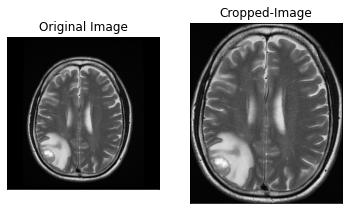

In [4]:
ex_crop_img = crop_brain_contour( cv2.imread(image_dir+'yes/Y107.jpg'), True)

In [5]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width=224
    image_height = 224
    if (dir_list=='../input/mri-test'):
        #print('mri')
        for filename in listdir(dir_list):
                #print("file name printing {}".format(filename))
                if(filename!='53.gif'):
#                     image = Image.open(dir_list+'/'+filename)
#                     image = image.convert('RGB')
#                     image = image.filter(ImageFilter.SHARPEN)
#                     image = image.filter(ImageFilter.EDGE_ENHANCE_MORE)
#                     image = np.array(image)
                    image = cv2.imread(dir_list+'/'+filename)
                    image = crop_brain_contour(image, plot=False)
                    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                    image = image / 255.
                    # convert image to numpy array and append it to X
                    X.append(image)
                    
                    if (filename=='18.jpg' or filename=='21.jpg' or filename=='24.jpg' or filename=='27.jpg' or filename=='30.jpg' or filename=='71.jpg' or filename=='94.jpg'):
                        y.append([0])
                        print('labeling')
                        print(filename)
                        
                    else:
                        y.append([1])
                        
                    
               
    else:
        for directory in dir_list:
            #print(directory)
            for filename in listdir(directory):
               # print(filename)
                image = cv2.imread(directory+'/'+filename)
                image = crop_brain_contour(image, plot=False)
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                image = image / 255.
                # convert image to numpy array and append it to X
                X.append(image)
                # append a value of 1 to the target array if the image
                # is in the folder named 'yes', otherwise append 0.
                
                if (directory=='../input/mri-test'):
                   # y.append([1])
                    print('hello')
                else:
                    if directory[-3:] == 'yes':
                        if (filename=='Y185' or filename=='Y187'):
                            y.append([0])
                        else:
                            y.append([1])
                    else:
                        if (filename=='N1' or filename=='N11' or filename=='N15' or filename=='N16' or filename=='N17' or filename=='N19' or filename=='N22'):
                            y.append([1])
                        else:
                            y.append([0])

            
                
    X = np.array(X)
    y = np.array(y)
    
#     # Shuffle the data
#     X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Number of examples is: 2318
X shape is: (2318, 224, 224, 3)
y shape is: (2318, 1)
labeling
21.jpg
labeling
94.jpg
labeling
30.jpg
labeling
71.jpg
labeling
18.jpg
labeling
27.jpg
labeling
24.jpg
Number of examples is: 90
X shape is: (90, 224, 224, 3)
y shape is: (90, 1)
(2318, 224, 224, 3)
example


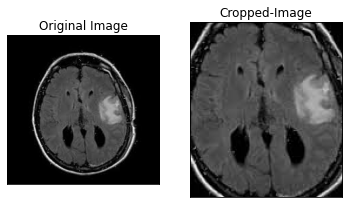

In [6]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X_train, y_train = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
test_dir='../input/mri-test'
X_test,y_test=load_data(test_dir, 240)
print(X_train.shape)
y_test=np.array(y_test)

print('example')
image = cv2.imread('../input/mri-test'+'/32.jpg')
ex_crop_img = crop_brain_contour(image, True)

## Visualization of data

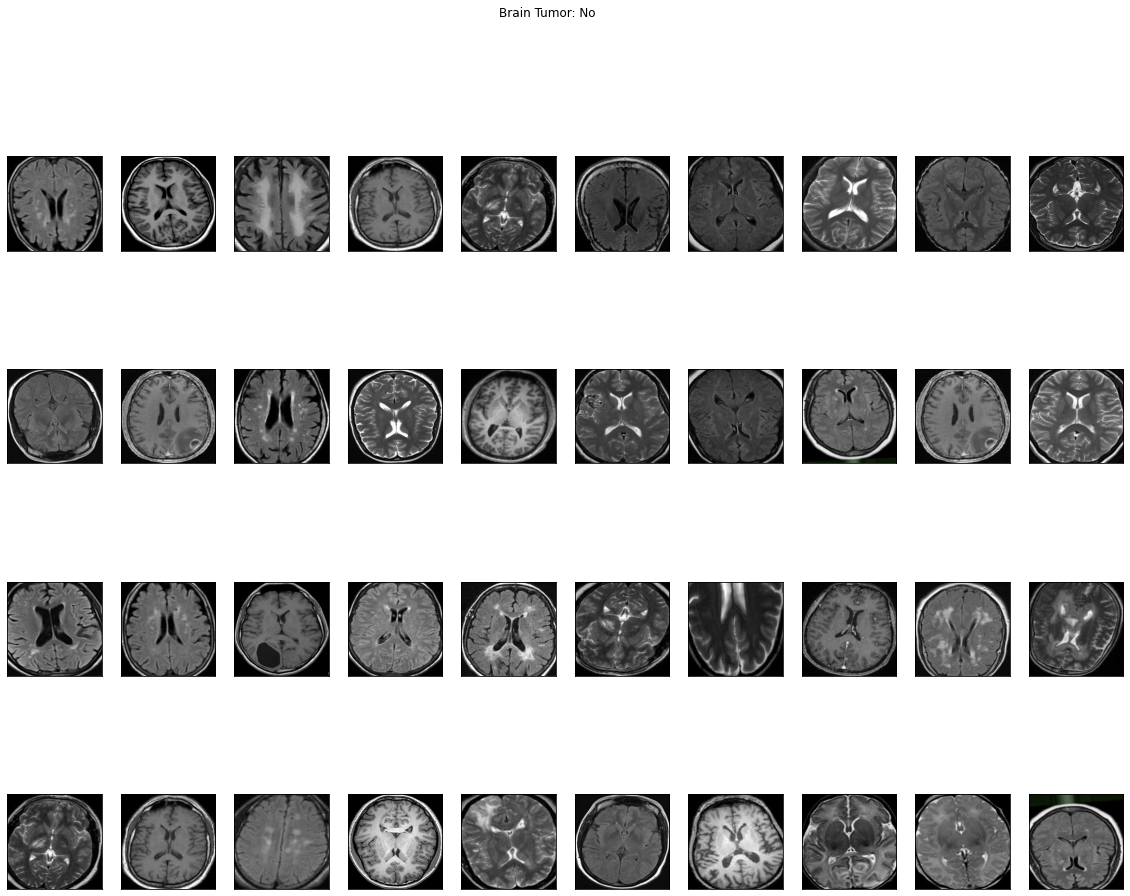

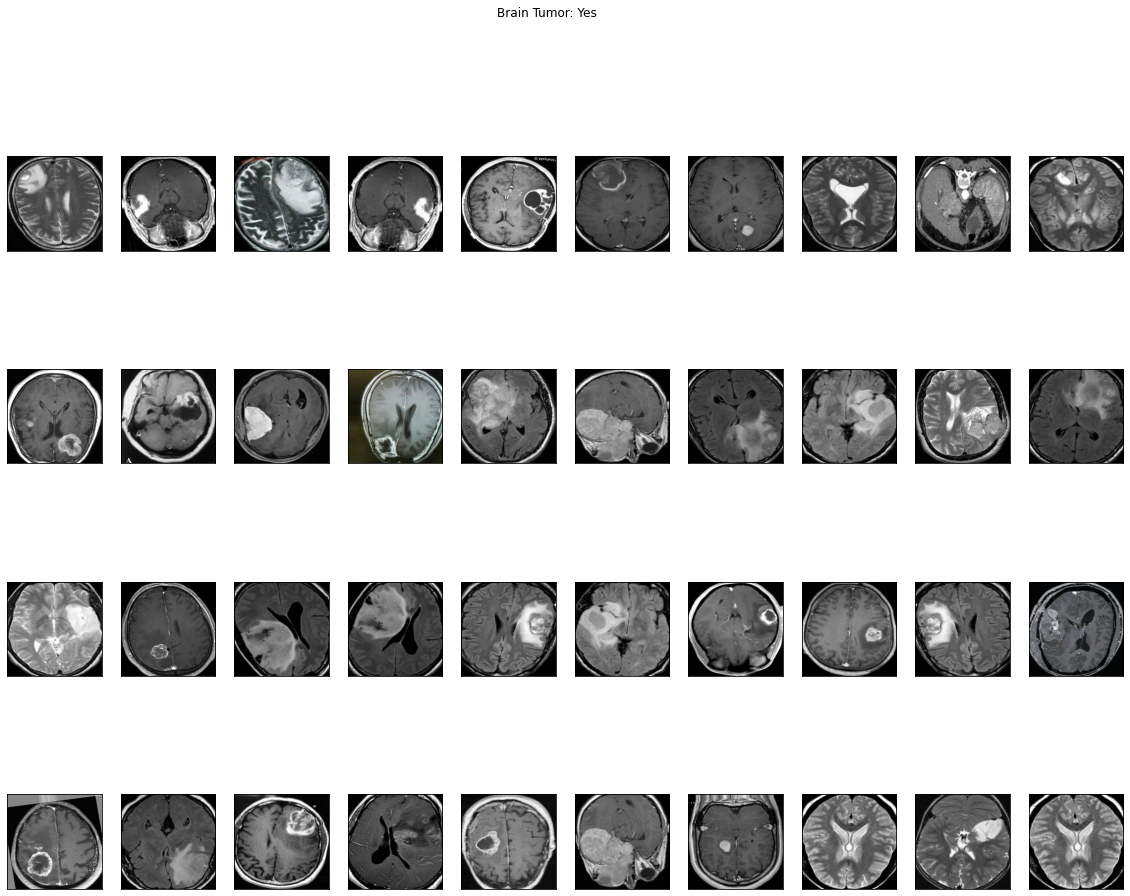

In [7]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 15))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
plot_sample_images(X_train, y_train)

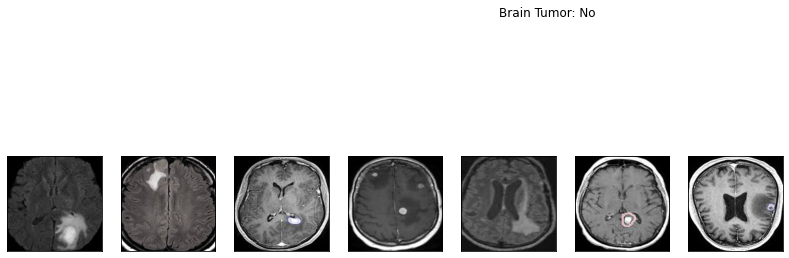

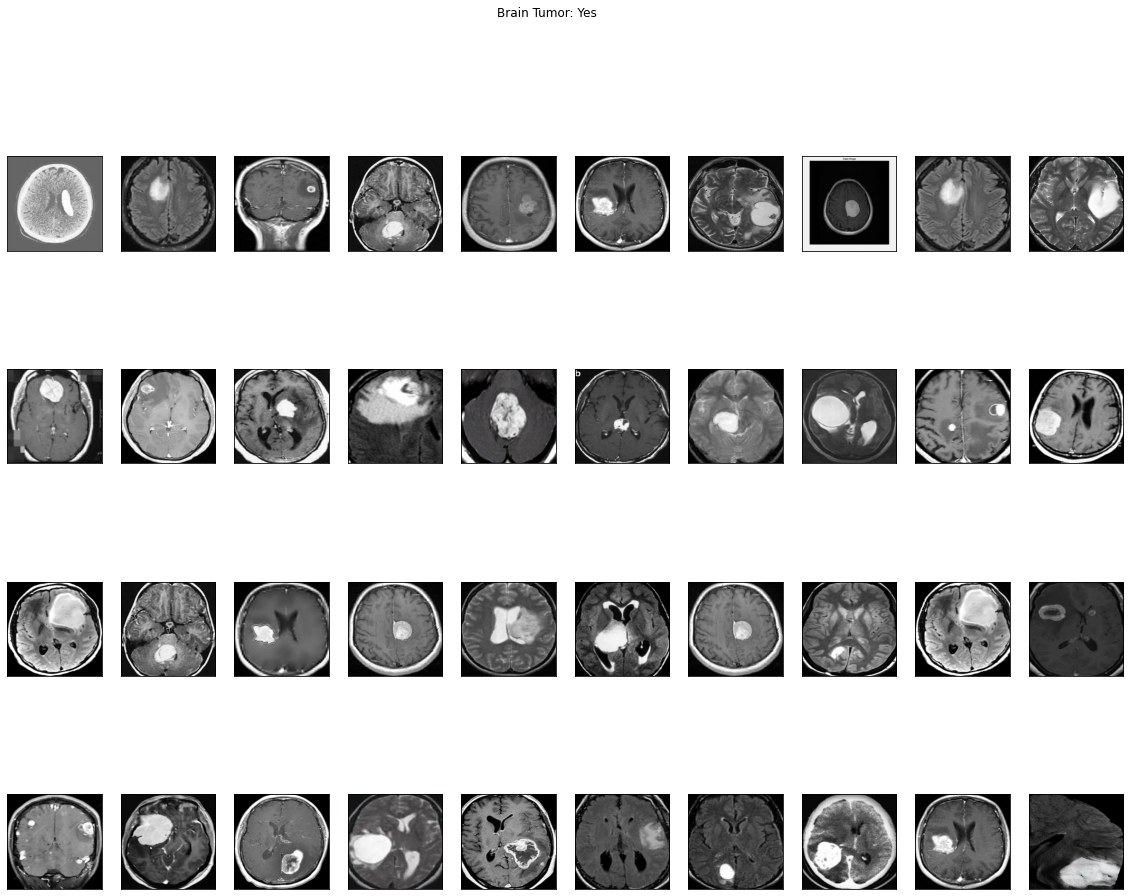

In [8]:
plot_sample_images(X_test, y_test)

In [9]:
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, BatchNormalization
from keras.layers import MaxPooling2D

IMG_SIZE = (224,224)
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=(224,224,3)
)

NUM_CLASSES = 1
model = Sequential()
model.add(base_model)
model.add(Conv2D(32, (7, 7), padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
model.layers[0].trainable = False
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          802848    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 15,517,569
Trainable params: 802,881
Non-trainable params: 14,714,688
____________________________________

In [10]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=80, validation_data=(X_test, y_test))
history = model.history.history

Train on 2318 samples, validate on 90 samples
Epoch 1/80
2318/2318 [==============================] - 13s 6ms/step - loss: 0.6421 - accuracy: 0.6484 - val_loss: 0.4613 - val_accuracy: 0.8889
Epoch 2/80
2318/2318 [==============================] - 8s 3ms/step - loss: 0.5177 - accuracy: 0.7588 - val_loss: 0.3711 - val_accuracy: 0.9000
Epoch 3/80
2318/2318 [==============================] - 8s 3ms/step - loss: 0.4443 - accuracy: 0.8270 - val_loss: 0.4035 - val_accuracy: 0.8444
Epoch 4/80
2318/2318 [==============================] - 8s 3ms/step - loss: 0.3957 - accuracy: 0.8550 - val_loss: 0.4058 - val_accuracy: 0.8111
Epoch 5/80
2318/2318 [==============================] - 8s 3ms/step - loss: 0.3522 - accuracy: 0.8775 - val_loss: 0.4885 - val_accuracy: 0.7333
Epoch 6/80
2318/2318 [==============================] - 8s 3ms/step - loss: 0.3153 - accuracy: 0.9021 - val_loss: 0.3297 - val_accuracy: 0.9222
Epoch 7/80
2318/2318 [==============================] - 8s 3ms/step - loss: 0.2964 - accu

### Plotting of aaccuracy

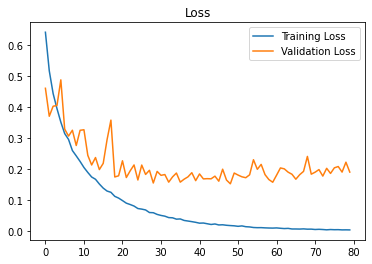

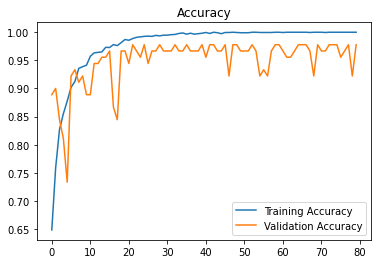

In [11]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
evaluation = pd.DataFrame({'Model': [],
                           'Accuracy(train)':[],
                           'Precision(train)':[],
                           'Recall(train)':[],
                           'F1_score(train)':[],
                           'Specificity(train)':[],
                           'Accuracy(test)':[],
                           'Precision(test)':[],
                           'Recalll(test)':[],
                           'F1_score(test)':[],
                           'Specificity(test)':[],
                          })
print(X_train.shape)

(2318, 224, 224, 3)


In [13]:
clf=model

prediction_train = clf.predict(X_train)
prediction_train = [1 if x>=0.5 else 0 for x in prediction_train]

prediction_test = clf.predict(X_test)
prediction_test = [1 if x>=0.4 else 0 for x in prediction_test]

acc_train=format(accuracy_score(prediction_train, y_train),'.3f')
precision_train=format(precision_score(y_train, prediction_train, average='weighted'),'.3f')
recall_train=format(recall_score(y_train,prediction_train, average='weighted'),'.3f')
f1_train=format(f1_score(y_train,prediction_train, average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(prediction_train, y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

acc_test=format(accuracy_score(prediction_test, y_test),'.3f')
precision_test=format(precision_score(y_test, prediction_test, average='weighted'),'.3f')
recall_test=format(recall_score(y_test,prediction_test, average='weighted'),'.3f')
f1_test=format(f1_score(y_test,prediction_test, average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(prediction_test, y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['Neural Network',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857

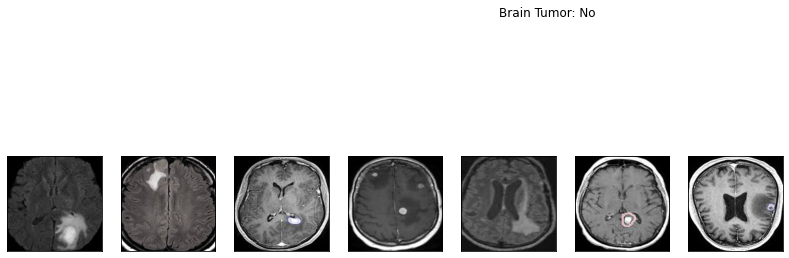

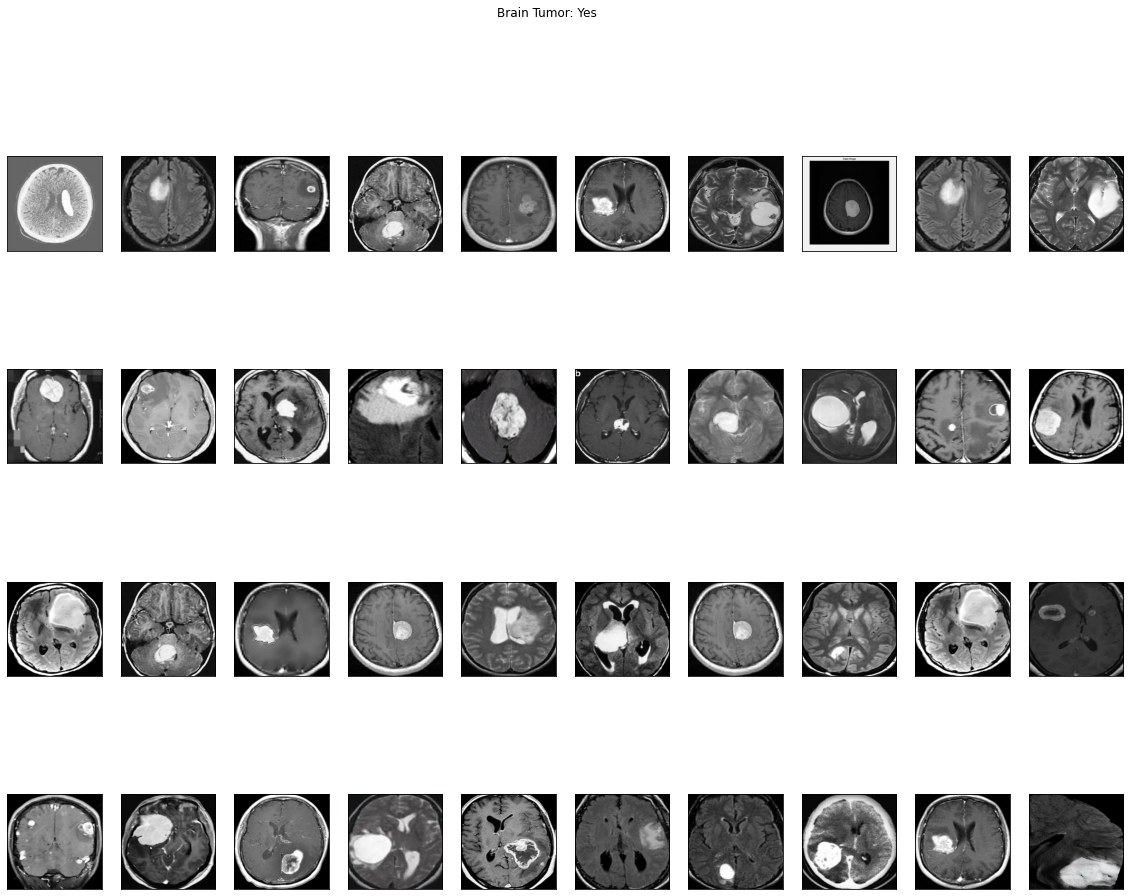

In [14]:
prediction_train = clf.predict(X_train)
prediction_train = [1 if x>=0.5 else 0 for x in prediction_train]

prediction_test = clf.predict(X_test)
prediction_test = [1 if x>=0.5 else 0 for x in prediction_test]
plot_sample_images(X_test, y_test)

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

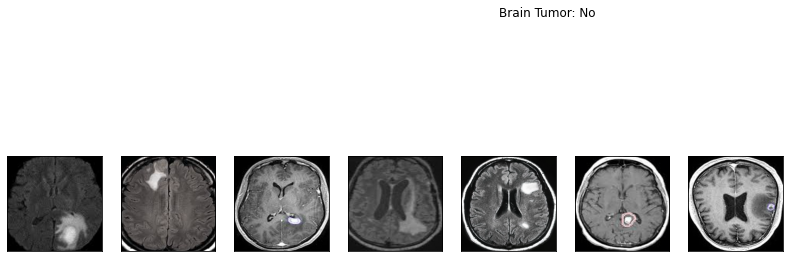

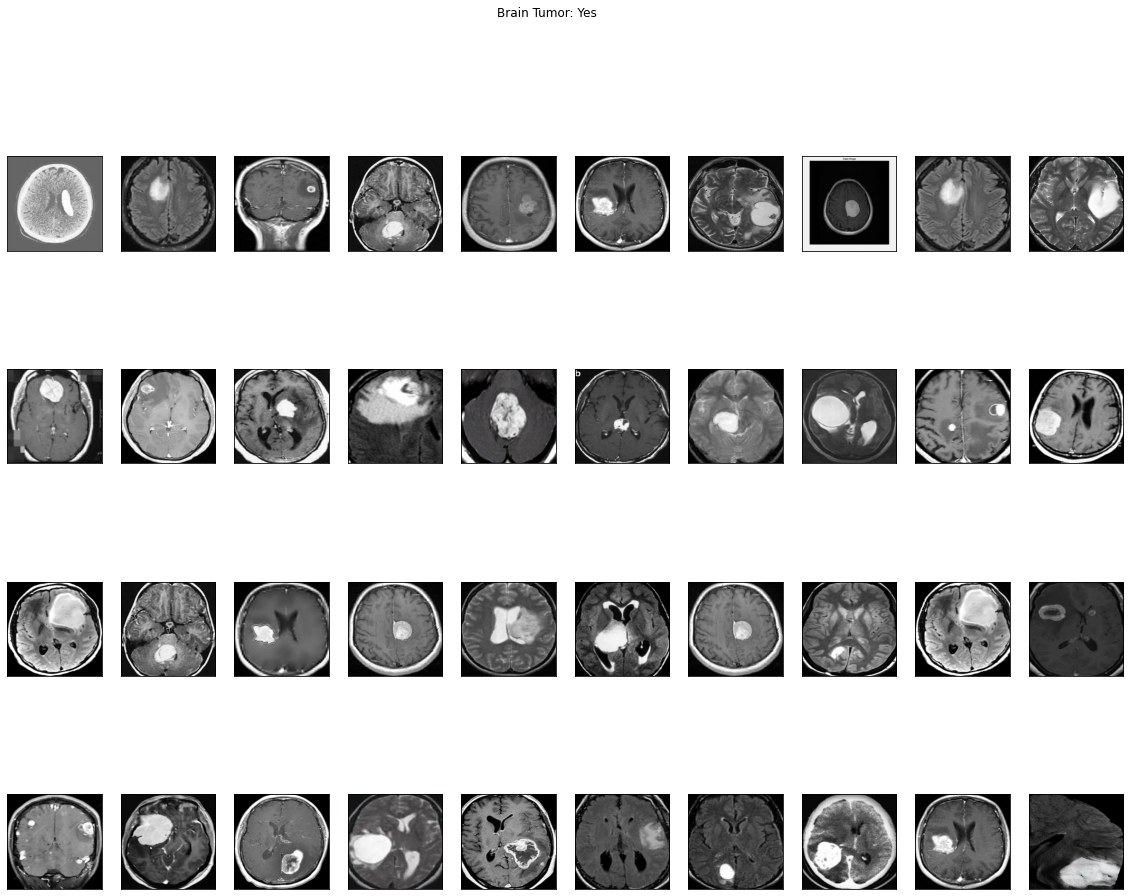

In [15]:
plot_sample_images(X_test, prediction_test)

prediction_test = np.array(prediction_test)
plot_sample_images(X_test, prediction_test)

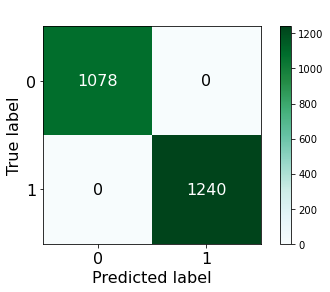

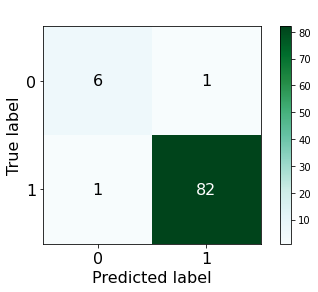

In [16]:
import scikitplot as skplt
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
# y_train=y_train.replace([0,1], ["Negative","Positive"])


pred_train=prediction_train
pred_train=pd.DataFrame(pred_train)
# pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=prediction_test
y_test = pd.DataFrame(y_test)
# y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

# pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


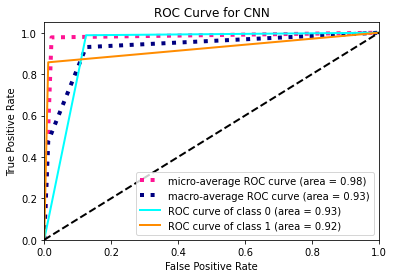

(90, 224, 224, 3)


In [17]:
#Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);    
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 
    
n_samples=90
n_features = 3
n_classes = 2


pred_test=clf.predict(X_test)
y_score = pred_test
y_score = [1 if x>=0.5 else 0 for x in y_score]


roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()
print(X_test.shape)

In [18]:
X_train

array([[[[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01568627, 0.01568627, 0.01568627],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01568627, 0.01568627, 0.01568627],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ]

In [19]:
p = X_train[0].flatten()
q = pd.Series(p)
q

cols = np.arange(q.shape[0])
df_train = pd.DataFrame(columns = cols)
df_test = pd.DataFrame(columns = cols)


xx=0
yy=0
for i in range(X_train.shape[0]):
    df_train.loc[xx] = X_train[i].flatten()
    xx = df_train.shape[0] + 1
    
for i in range(X_test.shape[0]):
    df_test.loc[yy] = X_test[i].flatten()
    yy = df_test.shape[0] + 1
    
print(df_train)
print()
print(df_test)

X_train = df_train.loc[:]
X_test = df_test.loc[:]

print(X_train)

        0         1         2         3         4         5         6       \
0     0.011765  0.011765  0.011765  0.011765  0.011765  0.011765  0.011765   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.047059  0.031373  0.027451  0.050980  0.031373  0.027451  0.058824   
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2314  0.031373  0.031373  0.031373  0.031373  0.031373  0.031373  0.031373   
2315  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843   
2316  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843   
2317  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843   
2318  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        7         8         9       ...    150518    150519    

# Random Forest Classifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [21]:
clf =RandomForestClassifier(n_estimators=100, random_state=500)
clf.fit(X_train, y_train)
acc_train=format(accuracy_score(clf.predict(X_train), y_train),'.3f')
precision_train=format(precision_score(y_train, clf.predict(X_train), average='weighted'),'.3f')
recall_train=format(recall_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
f1_train=format(f1_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_train), y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

y_test[50]=0
acc_test=format(accuracy_score(clf.predict(X_test), y_test),'.3f')
precision_test=format(precision_score(y_test, clf.predict(X_test), average='weighted'),'.3f')
recall_test=format(recall_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
f1_test=format(f1_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   
1   Random Forest           1.000            1.000         1.000   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   
1           1.000              1.000          0.800           0.866   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857  
1         0.800          0.828             0.188

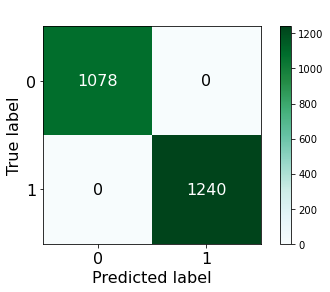

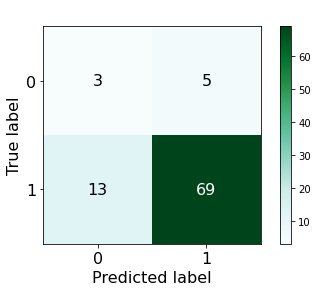

In [22]:
import scikitplot as skplt
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
# y_train=y_train.replace([0,1], ["Negative","Positive"])

pred_train=clf.predict(X_train)
pred_train=pd.DataFrame(pred_train)
# pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=clf.predict(X_test)
y_score = pred_test
y_test = pd.DataFrame(y_test)
# y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

# pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


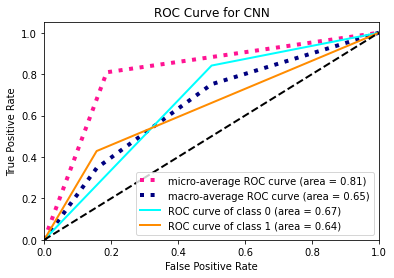

In [23]:
# #Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 

pred_test=clf.predict(X_test)
y_score = pred_test
n_samples, n_features = X_test.shape
n_classes = 2
roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()

# Support Vector Machine

In [24]:
clf =svm.SVC()
clf.fit(X_train, y_train)
acc_train=format(accuracy_score(clf.predict(X_train), y_train),'.3f')
precision_train=format(precision_score(y_train, clf.predict(X_train), average='binary'),'.3f')
recall_train=format(recall_score(y_train,clf.predict(X_train), average='binary'),'.3f')
f1_train=format(f1_score(y_train,clf.predict(X_train), average='binary'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_train), y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

y_test[50]=0
acc_test=format(accuracy_score(clf.predict(X_test), y_test),'.3f')
precision_test=format(precision_score(y_test, clf.predict(X_test), average='binary'),'.3f')
recall_test=format(recall_score(y_test,clf.predict(X_test), average='binary'),'.3f')
f1_test=format(f1_score(y_test,clf.predict(X_test), average='binary'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['SVM',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   
2             SVM           0.968            0.979         0.960   
1   Random Forest           1.000            1.000         1.000   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   
2           0.969              0.955          0.822           0.946   
1           1.000              1.000          0.800           0.866   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857  
2         0.854          0.897             0.250  
1         0.800          0.828             0.188

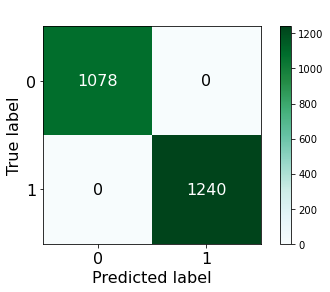

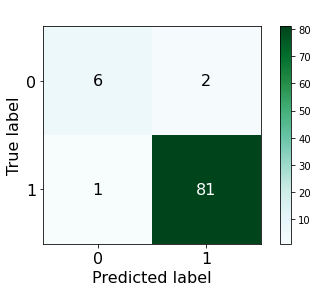

In [25]:
import scikitplot as skplt
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
# y_train=y_train.replace([0,1], ["Negative","Positive"])


pred_train=prediction_train
pred_train=pd.DataFrame(pred_train)
# pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=prediction_test
y_test = pd.DataFrame(y_test)
# y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

# pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


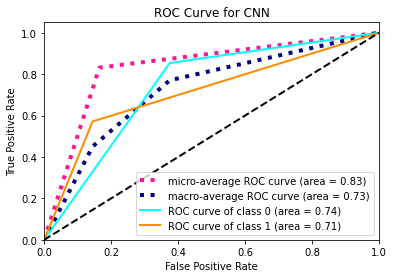

In [26]:
# #Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 

pred_test=clf.predict(X_test)
y_score = pred_test
n_samples, n_features = X_test.shape
n_classes = 2
roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()

# Decision Tree Classifier

In [27]:
from sklearn import tree
clf =tree.DecisionTreeClassifier(random_state=500)
clf.fit(X_train, y_train)
acc_train=format(accuracy_score(clf.predict(X_train), y_train),'.3f')
precision_train=format(precision_score(y_train, clf.predict(X_train), average='weighted'),'.3f')
recall_train=format(recall_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
f1_train=format(f1_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_train), y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

y_test[50]=0
acc_test=format(accuracy_score(clf.predict(X_test), y_test),'.3f')
precision_test=format(precision_score(y_test, clf.predict(X_test), average='weighted'),'.3f')
recall_test=format(recall_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
f1_test=format(f1_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   
2             SVM           0.968            0.979         0.960   
1   Random Forest           1.000            1.000         1.000   
3   Decision Tree           1.000            1.000         1.000   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   
2           0.969              0.955          0.822           0.946   
1           1.000              1.000          0.800           0.866   
3           1.000              1.000          0.733           0.885   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857  
2         0.854          0.897             0.250  
1         0.800          0.828             0.188  
3         0.733          0.787             0.192

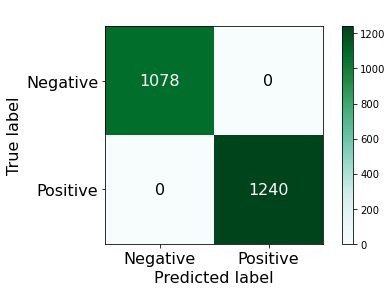

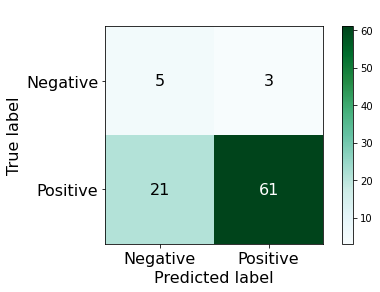

In [28]:
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
y_train=y_train.replace([0,1], ["Negative","Positive"])

pred_train=clf.predict(X_train)
pred_train=pd.DataFrame(pred_train)
pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=clf.predict(X_test)
y_score = pred_test
y_test = pd.DataFrame(y_test)
y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


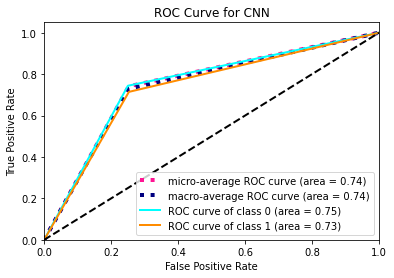

In [29]:
# #Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 

pred_test=clf.predict(X_test)
y_score = pred_test
n_samples, n_features = X_test.shape
n_classes = 2
roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()

# K-Nearest Neighbor

In [30]:
clf =KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
acc_train=format(accuracy_score(clf.predict(X_train), y_train),'.3f')
precision_train=format(precision_score(y_train, clf.predict(X_train), average='weighted'),'.3f')
recall_train=format(recall_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
f1_train=format(f1_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_train), y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')
y_test[50]=0
acc_test=format(accuracy_score(clf.predict(X_test), y_test),'.3f')
precision_test=format(precision_score(y_test, clf.predict(X_test), average='weighted'),'.3f')
recall_test=format(recall_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
f1_test=format(f1_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['KNN',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   
2             SVM           0.968            0.979         0.960   
1   Random Forest           1.000            1.000         1.000   
3   Decision Tree           1.000            1.000         1.000   
4             KNN           1.000            1.000         1.000   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   
2           0.969              0.955          0.822           0.946   
1           1.000              1.000          0.800           0.866   
3           1.000              1.000          0.733           0.885   
4           1.000              1.000          0.556           0.847   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857  
2         0.854          0.897             0.250  
1         0.800          0.828             0.188  
3         0.733          0.787             0.192  
4         0.556          0.650             0.100

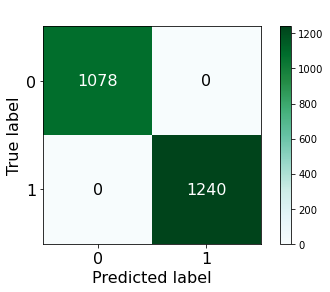

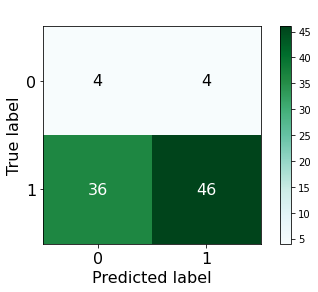

In [31]:
import scikitplot as skplt
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
# # y_train=y_train.replace([0,1], ["Negative","Positive"])

pred_train=clf.predict(X_train)
pred_train=pd.DataFrame(pred_train)
# pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=clf.predict(X_test)
y_score = pred_test
y_test = pd.DataFrame(y_test)
# y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

# pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test,  
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


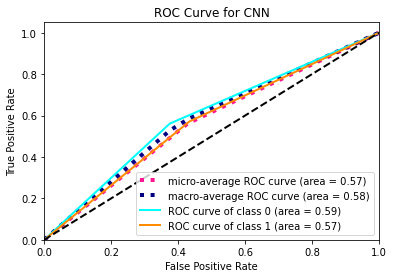

In [32]:
# #Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 

pred_test=clf.predict(X_test)
y_score = pred_test
n_samples, n_features = X_test.shape
n_classes = 2
roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()

# ANN CLassifier

In [33]:
clf =MLPClassifier()
clf.fit(X_train, y_train)
acc_train=format(accuracy_score(clf.predict(X_train), y_train),'.3f')
precision_train=format(precision_score(y_train, clf.predict(X_train), average='weighted'),'.3f')
recall_train=format(recall_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
f1_train=format(f1_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_train), y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

y_test[50]=0
acc_test=format(accuracy_score(clf.predict(X_test), y_test),'.3f')
precision_test=format(precision_score(y_test, clf.predict(X_test), average='weighted'),'.3f')
recall_test=format(recall_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
f1_test=format(f1_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['ANN',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   
2             SVM           0.968            0.979         0.960   
1   Random Forest           1.000            1.000         1.000   
3   Decision Tree           1.000            1.000         1.000   
4             KNN           1.000            1.000         1.000   
5             ANN           0.807            0.848         0.807   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   
2           0.969              0.955          0.822           0.946   
1           1.000              1.000          0.800           0.866   
3           1.000              1.000          0.733           0.885   
4           1.000              1.000          0.556           0.847   
5           0.804              0.715          0.556           0.884   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857  
2         0.854          0.897             0.250  
1         0.800          0.828             0.188  
3         0.733          0.787             0.192  
4         0.556          0.650             0.100  
5         0.556          0.647             0.136

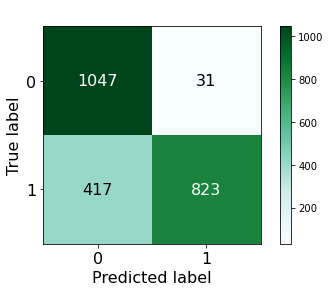

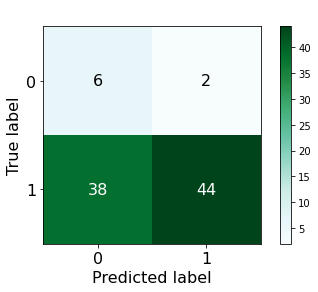

In [34]:
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
# y_train=y_train.replace([0,1], ["Negative","Positive"])

pred_train=clf.predict(X_train)
pred_train=pd.DataFrame(pred_train)
# pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=clf.predict(X_test)
y_score = pred_test
y_test = pd.DataFrame(y_test)
# y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

# pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


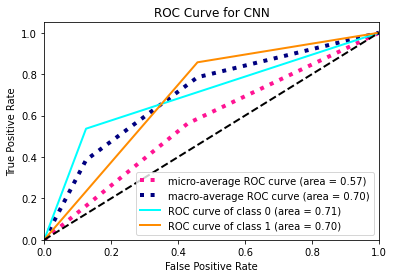

In [35]:
#Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);    
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 
    
n_samples, n_features = X_test.shape
n_classes = 2

roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()

# Gaussian Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB
clf =GaussianNB()
clf.fit(X_train, y_train)
acc_train=format(accuracy_score(clf.predict(X_train), y_train),'.3f')
precision_train=format(precision_score(y_train, clf.predict(X_train), average='weighted'),'.3f')
recall_train=format(recall_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
f1_train=format(f1_score(y_train,clf.predict(X_train), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_train), y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

y_test[50]=0
acc_test=format(accuracy_score(clf.predict(X_test), y_test),'.3f')
precision_test=format(precision_score(y_test, clf.predict(X_test), average='weighted'),'.3f')
recall_test=format(recall_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
f1_test=format(f1_score(y_test,clf.predict(X_test), average='weighted'),'.3f')
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['Naive Bayes',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model Accuracy(train) Precision(train) Recall(train)  \
0  Neural Network           1.000            1.000         1.000   
2             SVM           0.968            0.979         0.960   
1   Random Forest           1.000            1.000         1.000   
3   Decision Tree           1.000            1.000         1.000   
6     Naive Bayes           0.611            0.635         0.611   
4             KNN           1.000            1.000         1.000   
5             ANN           0.807            0.848         0.807   

  F1_score(train) Specificity(train) Accuracy(test) Precision(test)  \
0           1.000              1.000          0.978           0.978   
2           0.969              0.955          0.822           0.946   
1           1.000              1.000          0.800           0.866   
3           1.000              1.000          0.733           0.885   
6           0.605              0.560          0.611           0.855   
4           1.000              1.000          0.556           0.847   
5           0.804              0.715          0.556           0.884   

  Recalll(test) F1_score(test) Specificity(test)  
0         0.978          0.978             0.857  
2         0.854          0.897             0.250  
1         0.800          0.828             0.188  
3         0.733          0.787             0.192  
6         0.611          0.695             0.114  
4         0.556          0.650             0.100  
5         0.556          0.647             0.136

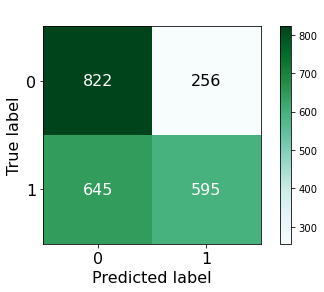

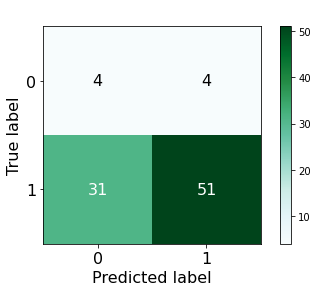

In [37]:
import scikitplot as skplt
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
# y_train=y_train.replace([0,1], ["Negative","Positive"])

pred_train=clf.predict(X_train)
pred_train=pd.DataFrame(pred_train)
# pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=clf.predict(X_test)
y_score = pred_test
y_test = pd.DataFrame(y_test)
# y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

# pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


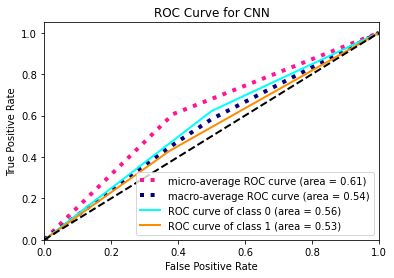

In [38]:
#Create another array arr2 with size of arr1    
roc_y_test = [None] * len(y_test);    
     
#Copying all elements of one array into another    
for i in range(0, len(y_test)):    
    roc_y_test[i] = y_test[i]; 
    
n_samples, n_features = X_test.shape
n_classes = 2

roc_y_test = y_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()